# Data Analytics Project - Models

# Pair 3 - TWL Linear Regression Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from regressors import stats

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 3 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair3/Pair3_orders.csv')
orders_df.head()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
0,2018-01-08,433.549988,177.449997,256.099991,1.441892,FLAT
1,2018-01-09,437.549988,174.800003,262.749985,1.987008,SHORT
2,2018-01-10,433.299988,171.399994,261.899994,1.917332,SHORT
3,2018-01-11,434.750000,175.149994,259.600006,1.728797,SHORT
4,2018-01-12,437.100006,174.050003,263.050003,2.011601,SHORT


In [3]:
orders_df.tail()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
55,2018-04-02,339.149994,114.199997,224.949997,-1.111545,FLAT
56,2018-04-03,343.100006,118.349998,224.750008,-1.127938,FLAT
57,2018-04-04,355.600006,114.849998,240.750008,0.183619,GET_OUT_OF_POSITION
58,2018-04-05,362.200012,116.900002,245.300011,0.556593,FLAT
59,2018-04-06,364.100006,119.599998,244.500008,0.491015,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

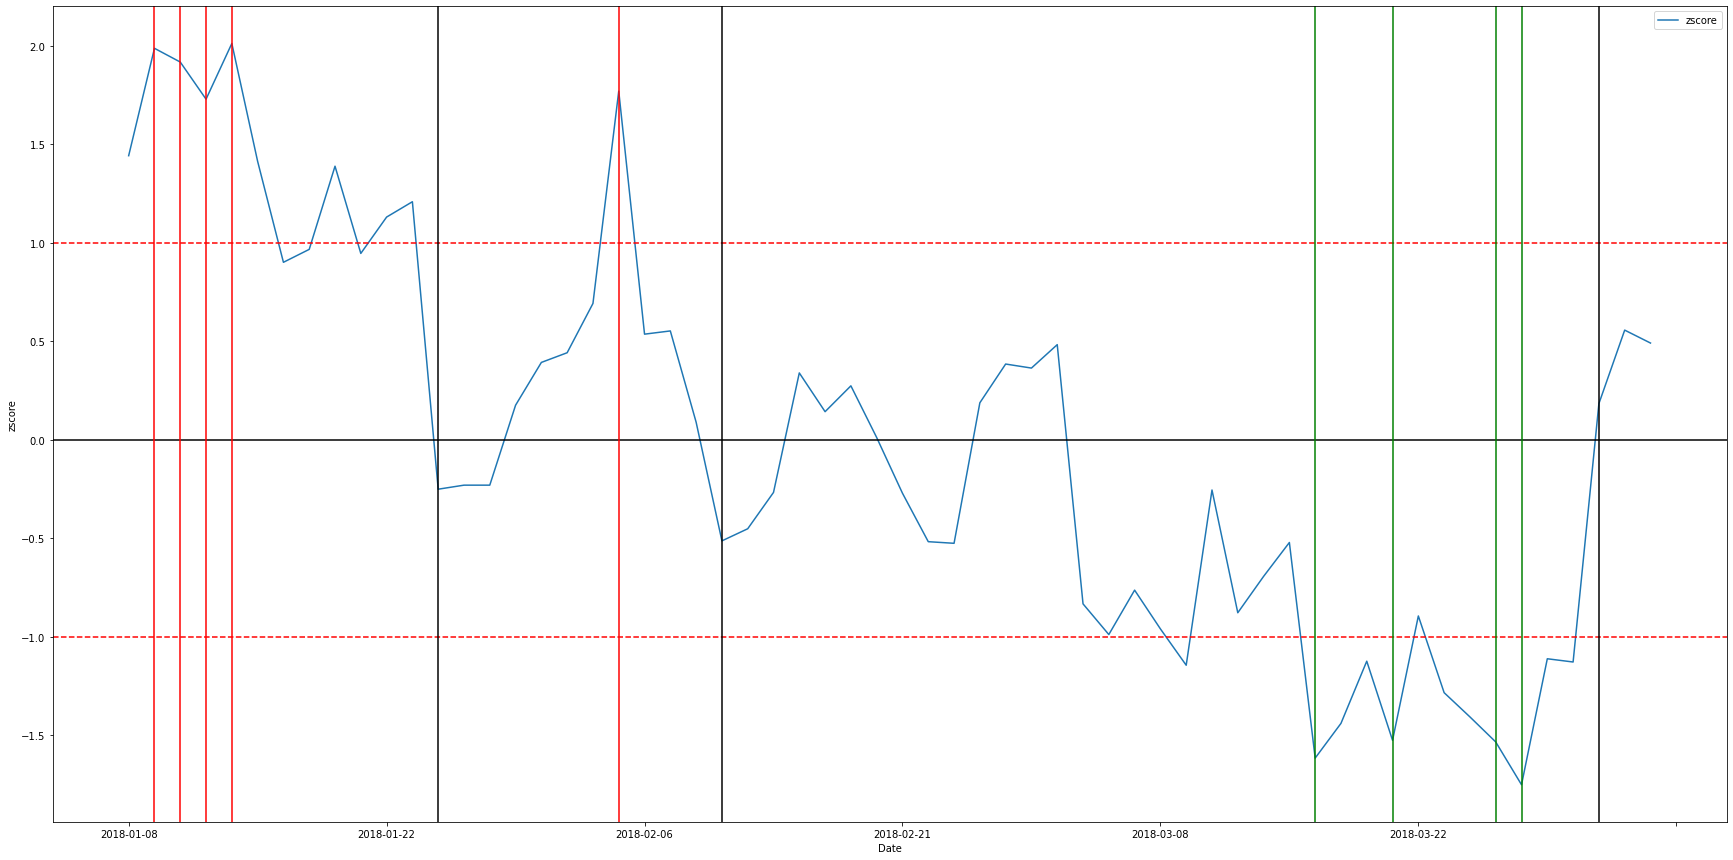

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

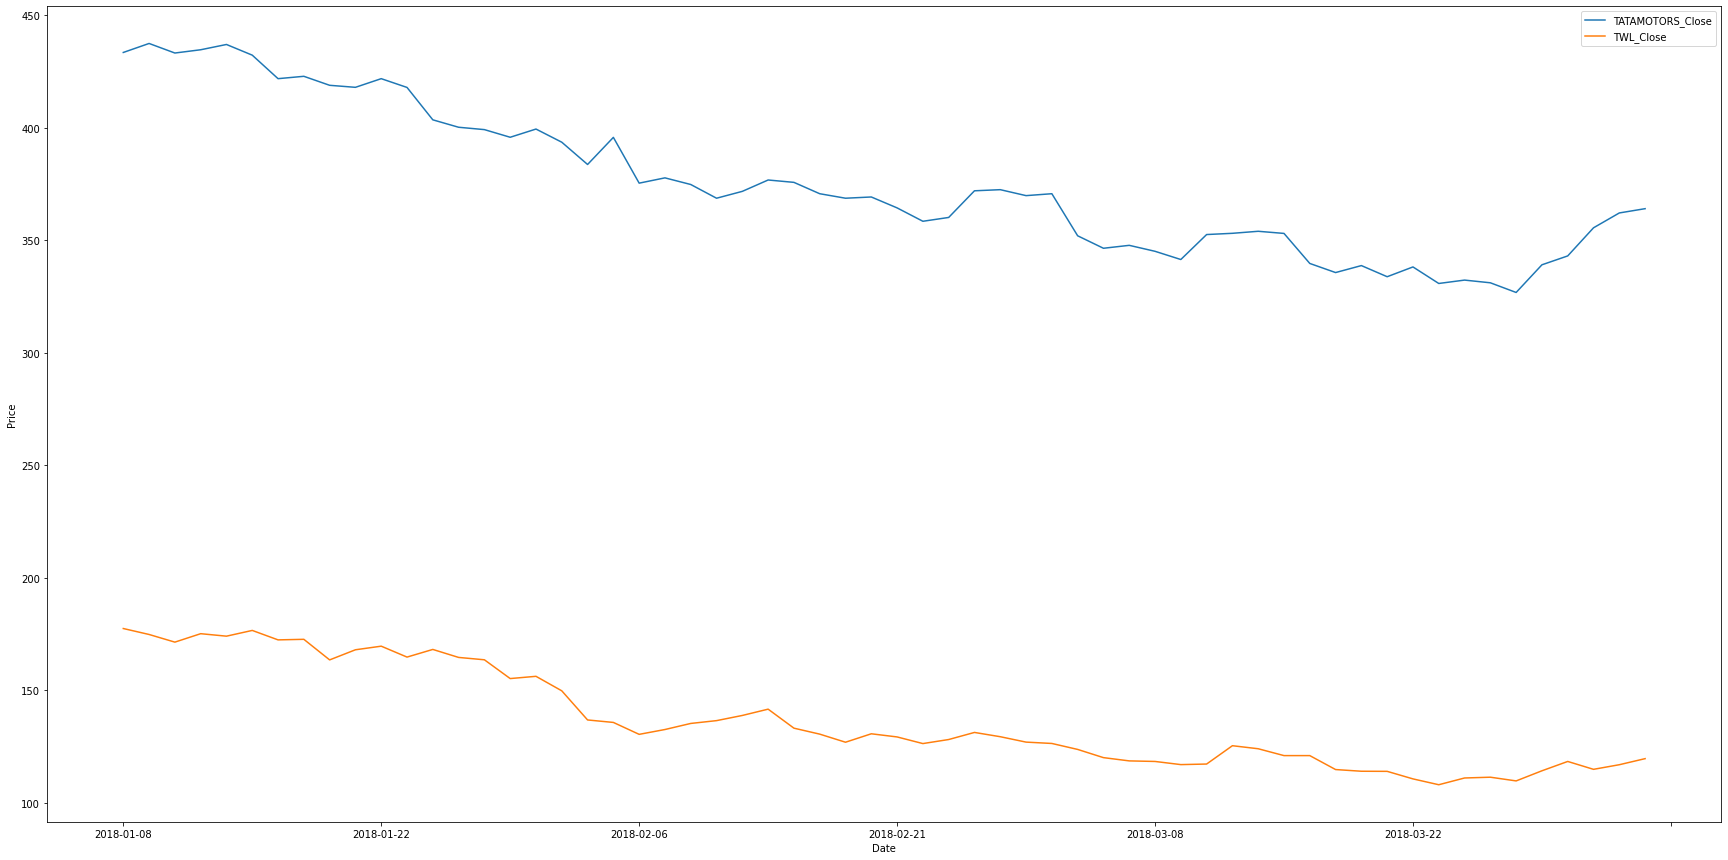

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TATAMOTORS_Close', 'TWL_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TWL Linear Regression Model

## 3.1. Get the Complete TWL dataset

In [6]:
twl_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TWLNSE.csv")
twl_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,125.800003,122.699997,124.000000,125.150002,657433.0,122.965851,TWL,NSE
1,2017-01-03,132.899994,125.500000,126.150002,130.800003,2992973.0,128.517227,TWL,NSE
2,2017-01-04,132.300003,127.000000,131.600006,128.449997,1281617.0,126.208244,TWL,NSE
3,2017-01-05,129.649994,124.099998,129.000000,126.900002,1125281.0,124.685303,TWL,NSE
4,2017-01-06,129.350006,125.550003,127.400002,127.400002,841568.0,125.176567,TWL,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TWL training data

### 3.2.1 Get complete twl dataset

In [7]:
twl_df = twl_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
twl_df.head()

,Date,Close
0,2017-01-02,125.150002
1,2017-01-03,130.800003
2,2017-01-04,128.449997
3,2017-01-05,126.900002
4,2017-01-06,127.400002


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
twl_df_train = twl_df[twl_df['Date'] >= '2017-09-03']
twl_df_train.head()

,Date,Close
166,2017-09-04,115.349998
167,2017-09-05,119.500000
168,2017-09-06,118.150002
169,2017-09-07,115.599998
170,2017-09-08,115.849998


In [9]:
twl_df_train = twl_df_train[twl_df_train['Date'] <= '2018-09-04']
twl_df_train.tail()

,Date,Close
412,2018-08-29,88.949997
413,2018-08-30,88.849998
414,2018-08-31,88.500000
415,2018-09-03,87.849998
416,2018-09-04,86.050003


### 3.2.3 Add extra date columns to the training data

In [10]:
add_datepart(twl_df_train, 'Date')

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
166,115.349998,2017,36,9,4,0,247,False,False,False,False,False,False,1504483200
167,119.500000,2017,36,9,5,1,248,False,False,False,False,False,False,1504569600
168,118.150002,2017,36,9,6,2,249,False,False,False,False,False,False,1504656000
169,115.599998,2017,36,9,7,3,250,False,False,False,False,False,False,1504742400
170,115.849998,2017,36,9,8,4,251,False,False,False,False,False,False,1504828800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,88.949997,2018,35,8,29,2,241,False,False,False,False,False,False,1535500800
413,88.849998,2018,35,8,30,3,242,False,False,False,False,False,False,1535587200
414,88.500000,2018,35,8,31,4,243,True,False,False,False,False,False,1535673600
415,87.849998,2018,36,9,3,0,246,False,False,False,False,False,False,1535932800


### 3.2.4 Get the training data and labels

In [11]:
twl_train_X = twl_df_train.copy()

In [12]:
twl_train_X = twl_train_X.reset_index(drop=True)
twl_train_X_plot = twl_train_X.copy()
twl_train_X = twl_train_X.drop(columns=["Elapsed", "Close"])
twl_train_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2017,36,9,4,0,247,False,False,False,False,False,False
1,2017,36,9,5,1,248,False,False,False,False,False,False
2,2017,36,9,6,2,249,False,False,False,False,False,False
3,2017,36,9,7,3,250,False,False,False,False,False,False
4,2017,36,9,8,4,251,False,False,False,False,False,False


In [13]:
twl_train_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
246,2018,35,8,29,2,241,False,False,False,False,False,False
247,2018,35,8,30,3,242,False,False,False,False,False,False
248,2018,35,8,31,4,243,True,False,False,False,False,False
249,2018,36,9,3,0,246,False,False,False,False,False,False
250,2018,36,9,4,1,247,False,False,False,False,False,False


In [14]:
twl_train_y = twl_df[(twl_df['Date'] >= '2017-09-04') & (twl_df['Date'] <= '2018-09-04')]['Close']
twl_train_y

166    115.349998
167    119.500000
168    118.150002
169    115.599998
170    115.849998
          ...    
412     88.949997
413     88.849998
414     88.500000
415     87.849998
416     86.050003
Name: Close, Length: 251, dtype: float64

In [15]:
len(twl_train_X)

251

In [16]:
len(twl_train_y)

251

## 3.3. Get TWL Test Data

In [17]:
twl_test_df = orders_df.copy()
twl_test_df = twl_df[(twl_df['Date'] >= '2018-09-04') & (twl_df['Date'] <= '2018-12-03')].copy()
twl_test_df.head()

,Date,Close
416,2018-09-04,86.050003
417,2018-09-05,84.900002
418,2018-09-06,85.949997
419,2018-09-07,87.349998
420,2018-09-10,86.199997


In [18]:
twl_test_df.tail()

,Date,Close
470,2018-11-27,70.699997
471,2018-11-28,69.599998
472,2018-11-29,68.500000
473,2018-11-30,68.800003
474,2018-12-03,69.699997


In [19]:
add_datepart(twl_test_df, 'Date')
twl_test_df.head()

,Close,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
416,86.050003,2018,36,9,4,1,247,False,False,False,False,False,False,1536019200
417,84.900002,2018,36,9,5,2,248,False,False,False,False,False,False,1536105600
418,85.949997,2018,36,9,6,3,249,False,False,False,False,False,False,1536192000
419,87.349998,2018,36,9,7,4,250,False,False,False,False,False,False,1536278400
420,86.199997,2018,37,9,10,0,253,False,False,False,False,False,False,1536537600


In [20]:
twl_test_X = twl_test_df.copy()
twl_test_X = twl_test_X.drop(columns=['Close', "Elapsed"])
twl_test_X.reset_index(drop=True, inplace=True)
twl_test_X.index += 251
twl_test_X.head()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
251,2018,36,9,4,1,247,False,False,False,False,False,False
252,2018,36,9,5,2,248,False,False,False,False,False,False
253,2018,36,9,6,3,249,False,False,False,False,False,False
254,2018,36,9,7,4,250,False,False,False,False,False,False
255,2018,37,9,10,0,253,False,False,False,False,False,False


In [21]:
twl_test_X.tail()

,Year,Week,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
305,2018,48,11,27,1,331,False,False,False,False,False,False
306,2018,48,11,28,2,332,False,False,False,False,False,False
307,2018,48,11,29,3,333,False,False,False,False,False,False
308,2018,48,11,30,4,334,True,False,False,False,False,False
309,2018,49,12,3,0,337,False,False,False,False,False,False


In [22]:
twl_test_y = twl_df[(twl_df['Date'] >= '2018-09-04') & (twl_df['Date'] <= '2018-12-03')]
twl_test_y.reset_index(drop=True, inplace=True)
twl_test_y.index += 251
twl_test_y = twl_test_y['Close']

In [23]:
twl_test_y

251    86.050003
252    84.900002
253    85.949997
254    87.349998
255    86.199997
256    85.449997
257    87.449997
258    89.050003
259    87.400002
260    85.250000
261    84.550003
262    79.449997
263    76.000000
264    76.650002
265    76.949997
266    74.949997
267    70.699997
268    69.750000
269    72.750000
270    71.250000
271    68.250000
272    67.099998
273    62.450001
274    65.050003
275    66.500000
276    68.099998
277    69.599998
278    71.099998
279    69.199997
280    68.849998
281    68.199997
282    67.900002
283    68.349998
284    66.699997
285    66.349998
286    68.199997
287    66.849998
288    67.349998
289    69.699997
290    70.800003
291    70.449997
292    70.550003
293    71.500000
294    72.099998
295    74.000000
296    73.550003
297    72.900002
298    72.500000
299    72.500000
300    75.300003
301    74.449997
302    74.449997
303    73.199997
304    71.400002
305    70.699997
306    69.599998
307    68.500000
308    68.800003
309    69.6999

In [24]:
len(twl_test_X)

59

In [25]:
len(twl_test_y)

59

## 3.4 Create and Train TWL Model

In [26]:
model = LinearRegression()
model = model.fit(twl_train_X, twl_train_y)

## 3.5. Get predictions

In [27]:
predictions = model.predict(twl_test_X)
predictions_df = pd.DataFrame(predictions, columns=['predictions'])
predictions_df.index += 251
predictions_df

,predictions
251,97.123234
252,97.166994
253,97.210755
254,97.254516
255,96.775293
256,96.819054
257,96.862814
258,96.950336
259,96.471113
260,96.514873


In [28]:
predictions_df['test_data'] = twl_test_y
predictions_df

,predictions,test_data
251,97.123234,86.050003
252,97.166994,84.900002
253,97.210755,85.949997
254,97.254516,87.349998
255,96.775293,86.199997
256,96.819054,85.449997
257,96.862814,87.449997
258,96.950336,89.050003
259,96.471113,87.400002
260,96.514873,85.250000


In [29]:
predictions = predictions_df['predictions']
predictions

251     97.123234
252     97.166994
253     97.210755
254     97.254516
255     96.775293
256     96.819054
257     96.862814
258     96.950336
259     96.471113
260     96.514873
261     96.558634
262     96.646155
263     96.166933
264     96.210693
265     96.254454
266     96.298215
267     96.341975
268    102.413973
269     86.837087
270     86.880848
271     86.924609
272     86.445386
273     86.489147
274     86.532907
275     86.576668
276     86.620429
277     86.141206
278     86.184967
279     86.228727
280     86.316248
281     85.837026
282     85.880786
283     85.924547
284     85.968308
285     86.012068
286     85.532846
287     85.576606
288     89.550479
289     96.734271
290     88.308075
291     87.828852
292     87.872613
293     87.916373
294     88.003895
295     87.524672
296     87.568433
297     87.612193
298     87.655954
299     87.699715
300     87.220492
301     87.264252
302     87.308013
303     87.351774
304     86.916312
305     86.960072
306     87

In [30]:
print('Mean Absolute Error:', metrics.mean_absolute_error(twl_test_y, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(twl_test_y, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(twl_test_y, predictions)))
print('R2 Score:', metrics.r2_score(twl_test_y, predictions))

Mean Absolute Error: 16.508792262499206
Mean Squared Error: 294.42393071742015
Root Mean Squared Error: 17.158785817108974
R2 Score: -5.298119493454917


## 3.6. Visualize the predicitons vs test data

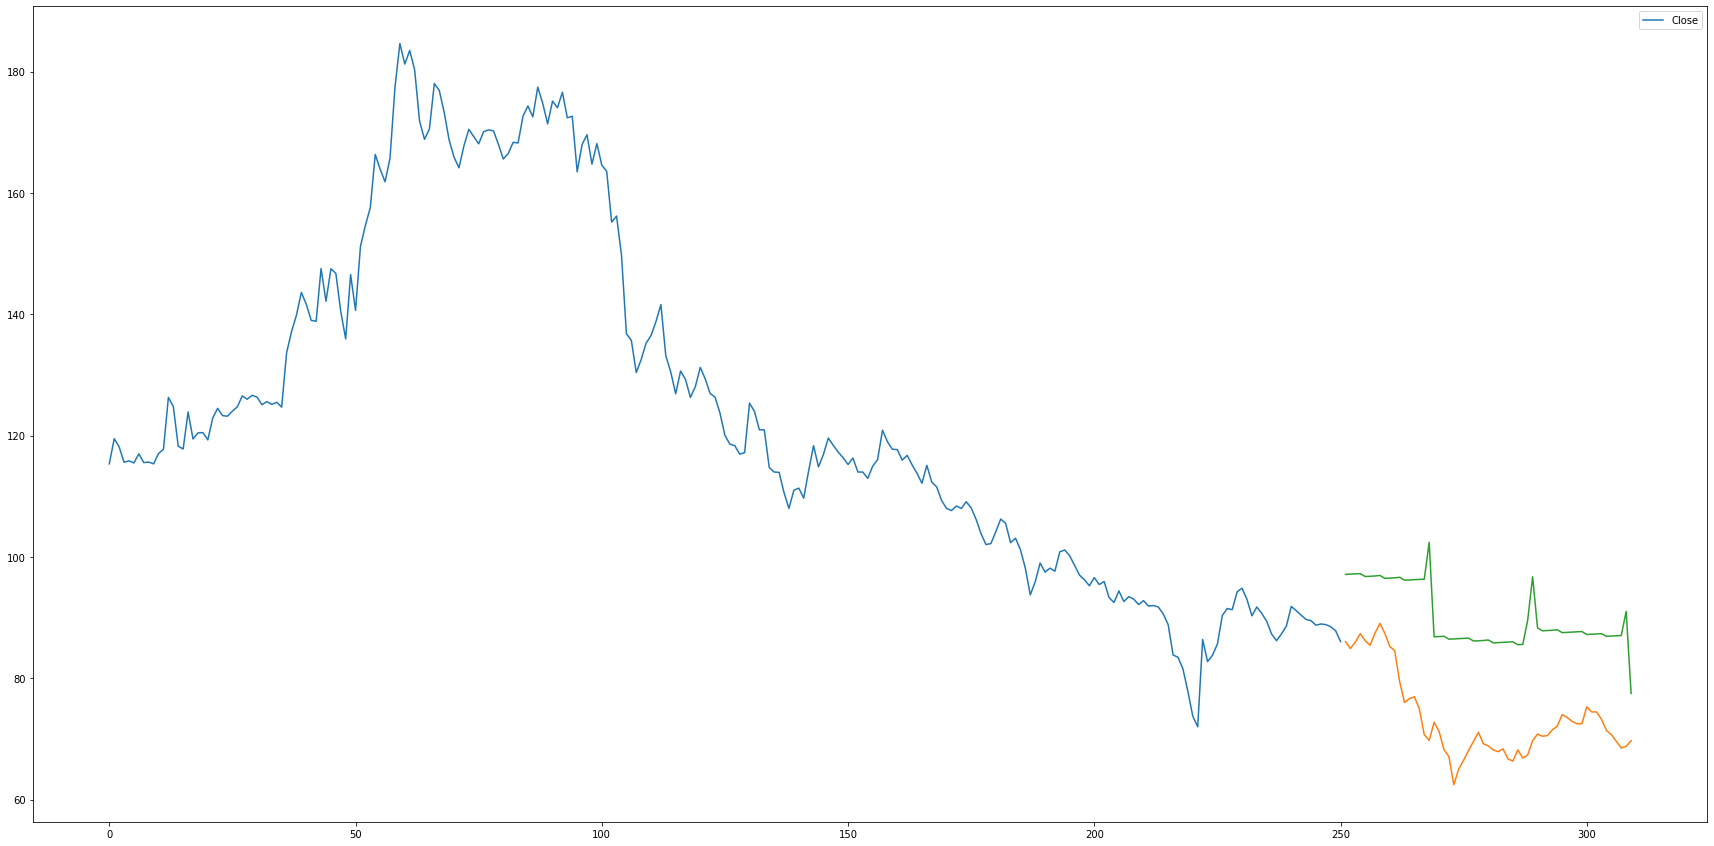

In [31]:
twl_model_plt = twl_train_X_plot.plot(y=['Close'], figsize=(30,15))
twl_model_plt.plot(predictions_df['test_data'])
twl_model_plt.plot(predictions_df['predictions'])

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results into a file

In [32]:
twl_predictions_data = {'Date': orders_df['Date'], 'Actual_Close': orders_df['TWL_Close']}
twl_predictions_df = pd.DataFrame(twl_predictions_data)
twl_predictions_df.head()

,Date,Actual_Close
0,2018-01-08,177.449997
1,2018-01-09,174.800003
2,2018-01-10,171.399994
3,2018-01-11,175.149994
4,2018-01-12,174.050003


In [33]:
predictions_df = predictions_df.reset_index()
twl_predictions_df['Linear_regression_Close'] = predictions_df['predictions']
twl_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-01-08,177.449997,97.123234
1,2018-01-09,174.800003,97.166994
2,2018-01-10,171.399994,97.210755
3,2018-01-11,175.149994,97.254516
4,2018-01-12,174.050003,96.775293


In [34]:
twl_predictions_df.to_csv('Twl_predicitions.csv', index=False)